# Concurrent Orchestration (Microsoft Agent Framework)

This notebook demonstrates a **concurrent fan-out/fan-in orchestration** with three role-specific agents — **Researcher**, **Marketer**, and **Legal** — using the Microsoft Agent Framework with Azure. Each code cell is preceded by an explanatory markdown cell for clarity.

## 📐 Workflow Architecture Diagram

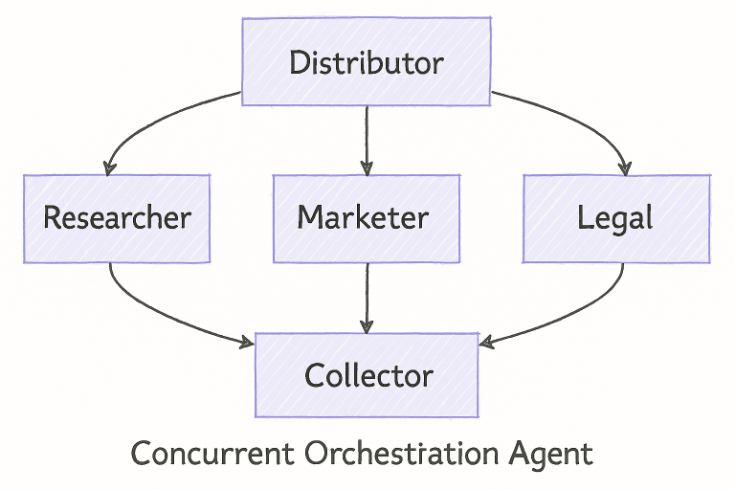

# 1) Imports

These imports pull in the Microsoft Agent Framework primitives, Azure client, and standard libraries needed for asynchronous execution and environment management.

In [2]:
# Standard libraries
import os
from dotenv import load_dotenv
import asyncio
from typing import Any

# Azure identity for authentication
from azure.identity import DefaultAzureCredential

# Microsoft Agent Framework types
from agent_framework.azure import AzureAIAgentClient
from agent_framework import (
    ChatAgent,
    WorkflowOutputEvent,
    ConcurrentBuilder,
    Message
)

# 2) Environment Setup

Load configuration from environment (or a local `.env`). We fail fast with a clear error if required variables are missing: `PROJECT_ENDPOINT` and `MODEL_DEPLOYMENT_NAME`.

In [3]:
# Load .env when running locally
load_dotenv()

def get_env(name: str) -> str:
    """Return env var value or raise a clear, actionable error.
    This makes misconfiguration obvious during setup.
    """
    value = os.getenv(name)
    if not value:
        raise RuntimeError(f"Missing environment variable: {name}")
    return value

PROJECT_ENDPOINT = get_env('PROJECT_ENDPOINT')
MODEL_DEPLOYMENT_NAME = get_env('MODEL_DEPLOYMENT_NAME')
print('Environment OK')


Environment OK


# 3) Create Azure Agent Client

We instantiate `AzureAIAgentClient` using `DefaultAzureCredential`. Recent Agent Framework builds allow agents to inherit the model from this client if not explicitly set in each `ChatAgent`.

In [4]:
credential = DefaultAzureCredential()
chat_client = AzureAIAgentClient(
    credential=credential,
    model_deployment_name=MODEL_DEPLOYMENT_NAME,
    project_endpoint=PROJECT_ENDPOINT
)
print('Azure Agent Client initialized.')


Azure Agent Client initialized.


# 4) Define Specialized Agents

In [5]:
researcher = ChatAgent(
    chat_client=chat_client,
    name='researcher',
    instructions=(
        "You're an expert market and product researcher. Provide concise, "
        "factual insights, opportunities, and risks."
    )
)

marketer = ChatAgent(
    chat_client=chat_client,
    name='marketer',
    instructions=(
        "You're a creative marketing strategist. Craft compelling value "
        "propositions and target messaging aligned to the prompt."
    )
)

legal = ChatAgent(
    chat_client=chat_client,
    name='legal',
    instructions=(
        "You're a cautious legal/compliance reviewer. Highlight constraints, "
        "disclaimers, and policy concerns based on the prompt."
    )
)

agents = [researcher, marketer, legal]
print('Agents registered:', ', '.join([a.name for a in agents]))


Agents registered: researcher, marketer, legal


# 5) Build the Concurrent Workflow

Wire the participants into a single **Concurrent** orchestration. The builder handles fan-out from the initial message to all agents and fan-in of their responses.

In [7]:
feedback = (
    'We are launching a new budget-friendly electric bike for urban commuters.'
)

workflow = ConcurrentBuilder().participants(agents).build()
print('Concurrent orchestration workflow built.')


Concurrent orchestration workflow built.


# 6) Execute and Display Aggregated Output

We stream workflow events. When the final `WorkflowOutputEvent` arrives, we iterate the collected `Message` objects and print a neat transcript. In notebooks we call `await main()` instead of `asyncio.run()`.

In [9]:
async def main() -> None:
    """Run the concurrent workflow and print aggregated results.
    The loop yields events; we capture the final output event to display
    a consolidated transcript from all agents.
    """
    output_evt: WorkflowOutputEvent | None = None
    async for event in workflow.run_stream(feedback):
        if isinstance(event, WorkflowOutputEvent):
            output_evt = event
            print('Output event received.')

    if output_evt:
        print("=========== Final Aggregated Conversation ===========")
        messages: list[Message] | Any = output_evt.data
        for i, msg in enumerate(messages, start=1):
            author = msg.author_name if msg.author_name else 'user'
            print(f"{'-'*60}\n{i:02d} [{author}]:\n{msg.text}")

await main()


Output event received.
=========== Final Aggregated Conversation ===========
------------------------------------------------------------
01 [user]:
We are launching a new budget-friendly electric bike for urban commuters.
------------------------------------------------------------
02 [researcher]:
### Market Insights

1. **Demand Growth**: The global electric bike market is expected to grow significantly, driven by increasing urbanization, environmental concerns, and a shift to eco-friendly transportation solutions. The demand for budget-friendly options is particularly strong among urban commuters looking for cost-effective mobility.

2. **Target Demographics**: Key demographics include young professionals, students, and environmentally-conscious individuals in urban areas who prioritize convenience and affordability over high-end features.

3. **Competitive Landscape**: There are established competitors such as Rad Power Bikes, Aventon, and Ancheer, which offer affordable electric 

# 7) Troubleshooting

- **Auth**: If authentication fails, run `az login` locally or configure Managed Identity in Azure.
- **Env vars**: Verify `PROJECT_ENDPOINT` and `MODEL_DEPLOYMENT_NAME`.
- **Model**: If agents fail to create, set `model=MODEL_DEPLOYMENT_NAME` explicitly in each `ChatAgent`.
